# Topic Modeling for Patent data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import nltk
import sys
import re, numpy as np, pandas as pd

In [7]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [4]:
patent=pd.read_csv('hassan_all_en_new.csv')

# Working with main text variable

In [5]:
patent_abst=patent['appln_abstr']

In [10]:
patent_abst[:5]

0    An electrical energy system including an elect...
1    An electrical energy system including an elect...
2    The regulating circuit has a microprocessor re...
3    A drive unit for an electric vehicle comprises...
4    A drive unit for an electric motor car compris...
Name: appln_abstr, dtype: object

In [12]:
patent_abst[2]

'The regulating circuit has a microprocessor regulator (1), receiving input signals representing monitored operating parameters of the vehicle and the electric drive motor (2) and control signals for input of operating commands. The regulator controls the current through the electric motor windings, in dependence on the received signals according to a stored control programme. At least one smoothing capacitor (12, 13, 29) is inserted between the battery (3) and the power inputs of the regulator, the latter switched to a battery charging mode, in which it controls the charging of the battery from an external AC network (4), according to a selected regulating programme.'

### 1.1)-Tokenize Sentences and Clean

In [13]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove extra characters
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [14]:
# Convert to list
data = patent.appln_abstr.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['an', 'electrical', 'energy', 'system', 'including', 'an', 'electric', 'utility', 'having', 'electricity', 'generation', 'apparatus', 'and', 'distribution', 'lines', 'plurality', 'of', 'electric', 'vehicles', 'and', 'electric', 'power', 'storage', 'apparatus', 'receiving', 'electrical', 'power', 'from', 'the', 'electric', 'utility', 'and', 'supplying', 'electrical', 'power', 'to', 'the', 'plurality', 'of', 'electric', 'vehicles', 'and', 'to', 'the', 'electric', 'utility', 'when', 'required', 'discharged', 'slurry', 'is', 'received', 'at', 'discharged', 'slurry', 'storage', 'facility', 'from', 'the', 'electric', 'vehicles', 'and', 'storage', 'battery', 'and', 'supplied', 'to', 'electrolytic', 'cells', 'via', 'suitable', 'pumps', 'the', 'charged', 'slurry', 'is', 'received', 'in', 'facility', 'and', 'then', 'stored', 'in', 'storage', 'battery', 'or', 'supplied', 'to', 'electric', 'vehicles', 'the', 'storage', 'battery', 'provides', 'when', 'necessary', 'or', 'economical', 'electrical',

In [15]:
print(data_words[2])

['the', 'regulating', 'circuit', 'has', 'microprocessor', 'regulator', 'receiving', 'input', 'signals', 'representing', 'monitored', 'operating', 'parameters', 'of', 'the', 'vehicle', 'and', 'the', 'electric', 'drive', 'motor', 'and', 'control', 'signals', 'for', 'input', 'of', 'operating', 'commands', 'the', 'regulator', 'controls', 'the', 'current', 'through', 'the', 'electric', 'motor', 'windings', 'in', 'dependence', 'on', 'the', 'received', 'signals', 'according', 'to', 'stored', 'control', 'programme', 'at', 'least', 'one', 'smoothing', 'capacitor', 'is', 'inserted', 'between', 'the', 'battery', 'and', 'the', 'power', 'inputs', 'of', 'the', 'regulator', 'the', 'latter', 'switched', 'to', 'battery', 'charging', 'mode', 'in', 'which', 'it', 'controls', 'the', 'charging', 'of', 'the', 'battery', 'from', 'an', 'external', 'ac', 'network', 'according', 'to', 'selected', 'regulating', 'programme']


### 1.2)-Build the Bigram, Trigram Models and Lemmatize

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# 2)-Build the Topic Model

### 2.1)- Create Dictionary

In [18]:

id2word = corpora.Dictionary(data_ready)

In [20]:
print(len(id2word))

15445


In [21]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 activity 48
1 apparatus 3342
2 battery 12121
3 cell 5141
4 charge 10096
5 combination 390
6 conversion 848
7 demand 1184
8 discharge 2895
9 disparate 1
10 distribution 1028


Filter out tokens that appear in
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 4000 most frequent tokens.

In [22]:
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=4000)

In [23]:
print(len(id2word))

3576


In [24]:
print (id2word[3])

cell


id2word is a dictionary that contains words. All of our data word.

### 2.2)-Create Corpus: Term Document Frequency

In [25]:

corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[500]

[(3, 3),
 (25, 1),
 (26, 1),
 (42, 1),
 (51, 2),
 (55, 3),
 (61, 1),
 (71, 1),
 (73, 4),
 (75, 1),
 (76, 2),
 (83, 1),
 (107, 2),
 (113, 2),
 (122, 1),
 (148, 1),
 (185, 1),
 (187, 3),
 (203, 1),
 (208, 1),
 (239, 1),
 (243, 1),
 (244, 1),
 (245, 1),
 (301, 1),
 (306, 1),
 (319, 1),
 (368, 1),
 (445, 1),
 (485, 1),
 (731, 1),
 (1095, 2),
 (1444, 1),
 (1549, 4),
 (1748, 2)]

In [26]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 3 ("cell") appears 3 time.
Word 25 ("provide") appears 1 time.
Word 26 ("pump") appears 1 time.
Word 42 ("circuit") appears 1 time.
Word 51 ("least") appears 2 time.
Word 55 ("motor") appears 3 time.
Word 61 ("regulating") appears 1 time.
Word 71 ("comprise") appears 1 time.
Word 73 ("cool") appears 4 time.
Word 75 ("flow") appears 1 time.
Word 76 ("fluid") appears 2 time.
Word 83 ("part") appears 1 time.
Word 107 ("device") appears 2 time.
Word 113 ("mount") appears 2 time.
Word 122 ("simplify") appears 1 time.
Word 148 ("compose") appears 1 time.
Word 185 ("desire") appears 1 time.
Word 187 ("fuel") appears 3 time.
Word 203 ("wherein") appears 1 time.
Word 208 ("feed") appears 1 time.
Word 239 ("distribute") appears 1 time.
Word 243 ("problem") appears 1 time.
Word 244 ("solution") appears 1 time.
Word 245 ("solve") appears 1 time.
Word 301 ("common") appears 1 time.
Word 306 ("identical") appears 1 time.
Word 319 ("main") appears 1 time.
Word 368 ("automobile") appears 1 time.


**From here, we can also make TF-IDF**

In [29]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [30]:
corpus_tfidf = tfidf[corpus]

In [31]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.17732180064525813),
 (1, 0.12558391365000096),
 (2, 0.0840493188270568),
 (3, 0.051167147243153646),
 (4, 0.0329505583194404),
 (5, 0.12077529761411333),
 (6, 0.09980979714754587),
 (7, 0.1816012696571704),
 (8, 0.13333513224109628),
 (9, 0.09461413718812478),
 (10, 0.30938745601874823),
 (11, 0.307957091609582),
 (12, 0.08240466722968766),
 (13, 0.16421703673324692),
 (14, 0.1000017765572616),
 (15, 0.25943849279070635),
 (16, 0.07802048294034801),
 (17, 0.05037047231770106),
 (18, 0.025409648483727988),
 (19, 0.10660457002405697),
 (20, 0.11369359546013429),
 (21, 0.0479023436309404),
 (22, 0.13292644402424114),
 (23, 0.19837973911358406),
 (24, 0.11184199861408592),
 (25, 0.04073481744226635),
 (26, 0.09244555704696522),
 (27, 0.17985150763978977),
 (28, 0.07349500255077428),
 (29, 0.1456812798093293),
 (30, 0.17967040043303334),
 (31, 0.40032227518020025),
 (32, 0.07093113637505699),
 (33, 0.11081779394911129),
 (34, 0.14867923415126044),
 (35, 0.16792035158720556),
 (36, 0.

### 2.3)-Build LDA model

In [32]:

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [33]:
#The trained topics (keywords and weights)
pprint(lda_model.print_topics())

[(0,
  '0.050*"motor" + 0.041*"engine" + 0.034*"drive" + 0.029*"first" + '
  '0.026*"speed" + 0.024*"hybrid" + 0.024*"torque" + 0.022*"gear" + '
  '0.018*"second" + 0.016*"output"'),
 (1,
  '0.122*"fuel" + 0.105*"cell" + 0.042*"air" + 0.039*"temperature" + '
  '0.034*"cool" + 0.034*"pressure" + 0.026*"stack" + 0.025*"water" + '
  '0.025*"system" + 0.020*"heat"'),
 (2,
  '0.028*"model" + 0.026*"utility" + 0.025*"connect" + 0.022*"automobile" + '
  '0.020*"motor" + 0.019*"end" + 0.016*"include" + 0.013*"first" + '
  '0.013*"side" + 0.013*"drive"'),
 (3,
  '0.053*"battery" + 0.051*"charge" + 0.032*"system" + 0.029*"voltage" + '
  '0.020*"unit" + 0.019*"module" + 0.017*"high" + 0.016*"controller" + '
  '0.015*"current" + 0.014*"circuit"')]


# 3)- analysis of LDA model

### 3.1)-the Dominant topic and its percentage contribution in each document

In [34]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7831,"battery, charge, system, voltage, unit, module...","[electrical, energy, system, include, electric..."
1,1,3.0,0.7688,"battery, charge, system, voltage, unit, module...","[electrical, energy, system, include, electric..."
2,2,3.0,0.7790,"battery, charge, system, voltage, unit, module...","[regulate, circuit, microprocessor, regulator,..."
3,3,2.0,0.5643,"model, utility, connect, automobile, motor, en...","[drive, unit, electric, vehicle, comprise, ele..."
4,4,2.0,0.6662,"model, utility, connect, automobile, motor, en...","[drive, unit, electric, motor, car, comprise, ..."
5,5,3.0,0.6151,"battery, charge, system, voltage, unit, module...","[control, circuit, controller, provide, microp..."
6,6,3.0,0.7362,"battery, charge, system, voltage, unit, module...","[system, board, charge, battery, electrical, v..."
7,7,0.0,0.5504,"motor, engine, drive, first, speed, hybrid, to...","[invention, drive, electric, vehicle, drive, s..."
8,8,1.0,0.7797,"fuel, cell, air, temperature, cool, pressure, ...","[method, thermal, management, fuel, cell, meth..."
9,9,1.0,0.7797,"fuel, cell, air, temperature, cool, pressure, ...","[method, thermal, management, fuel, cell, meth..."


In [39]:
print(df_dominant_topic['Text'][2])

['regulate', 'circuit', 'microprocessor', 'regulator', 'receive', 'input', 'signal', 'represent', 'monitor', 'operate', 'parameter', 'vehicle', 'electric', 'drive', 'motor', 'control', 'signal', 'input', 'operating', 'command', 'regulator', 'control', 'current', 'electric', 'motor', 'winding', 'dependence', 'receive', 'signal', 'accord', 'store', 'control', 'programme', 'least', 'insert', 'battery', 'power', 'input', 'regulator', 'latter', 'switch', 'battery', 'charge', 'mode', 'control', 'charge', 'battery', 'external', 'network', 'accord', 'select', 'regulating', 'programme']


**Compare with original text i.e uncleaned**

'The regulating circuit has a microprocessor regulator (1), receiving input signals representing monitored operating parameters of the vehicle and the electric drive motor (2) and control signals for input of operating commands. The regulator controls the current through the electric motor windings, in dependence on the received signals according to a stored control programme. At least one smoothing capacitor (12, 13, 29) is inserted between the battery (3) and the power inputs of the regulator, the latter switched to a battery charging mode, in which it controls the charging of the battery from an external AC network (4), according to a selected regulating programme.

### 3.2)-The most representative sentence for each topic

In [40]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9924,"motor, engine, drive, first, speed, hybrid, torque, gear, second, output","[invention, provide, transmission, device, hybrid, vehicle, comprise, first, differential, gear,..."
1,1.0,0.9638,"fuel, cell, air, temperature, cool, pressure, stack, water, system, heat","[disclose, hydrogen, recirculation, apparatus, fuel, cell, vehicle, specifically, apparatus, inc..."
2,2.0,0.9904,"model, utility, connect, automobile, motor, end, include, first, side, drive","[utility, model, disclose, motor, bracket, exclusively, electric, automobile, comprise, motor, f..."
3,3.0,0.9931,"battery, charge, system, voltage, unit, module, high, controller, current, circuit","[abnormal, battery, detect, system, electric, vehicle, include, power, supply, unit, display, un..."


In [43]:
print(sent_topics_sorteddf_mallet['Representative Text'][0])

['invention', 'provide', 'transmission', 'device', 'hybrid', 'vehicle', 'comprise', 'first', 'differential', 'gear', 'set', 'first', 'second', 'third', 'component', 'second', 'differential', 'gear', 'set', 'first', 'second', 'third', 'component', 'first', 'component', 'second', 'differential', 'gear', 'set', 'continuously', 'connect', 'first', 'component', 'first', 'differential', 'gear', 'set', 'first', 'torque', 'transmission', 'unit', 'capable', 'selectively', 'connect', 'second', 'component', 'first', 'differential', 'gear', 'set', 'third', 'component', 'second', 'differential', 'gear', 'set', 'second', 'torque', 'transmission', 'unit', 'capable', 'limit', 'rotation', 'third', 'component', 'second', 'differential', 'gear', 'set', 'first', 'electric', 'generator', 'connect', 'third', 'component', 'first', 'differential', 'gear', 'set', 'second', 'electric', 'generator', 'connect', 'first', 'component', 'second', 'differential', 'gear', 'set', 'second', 'component', 'first', 'differe

### 3.3)-Frequency Distribution of Word Counts in Documents

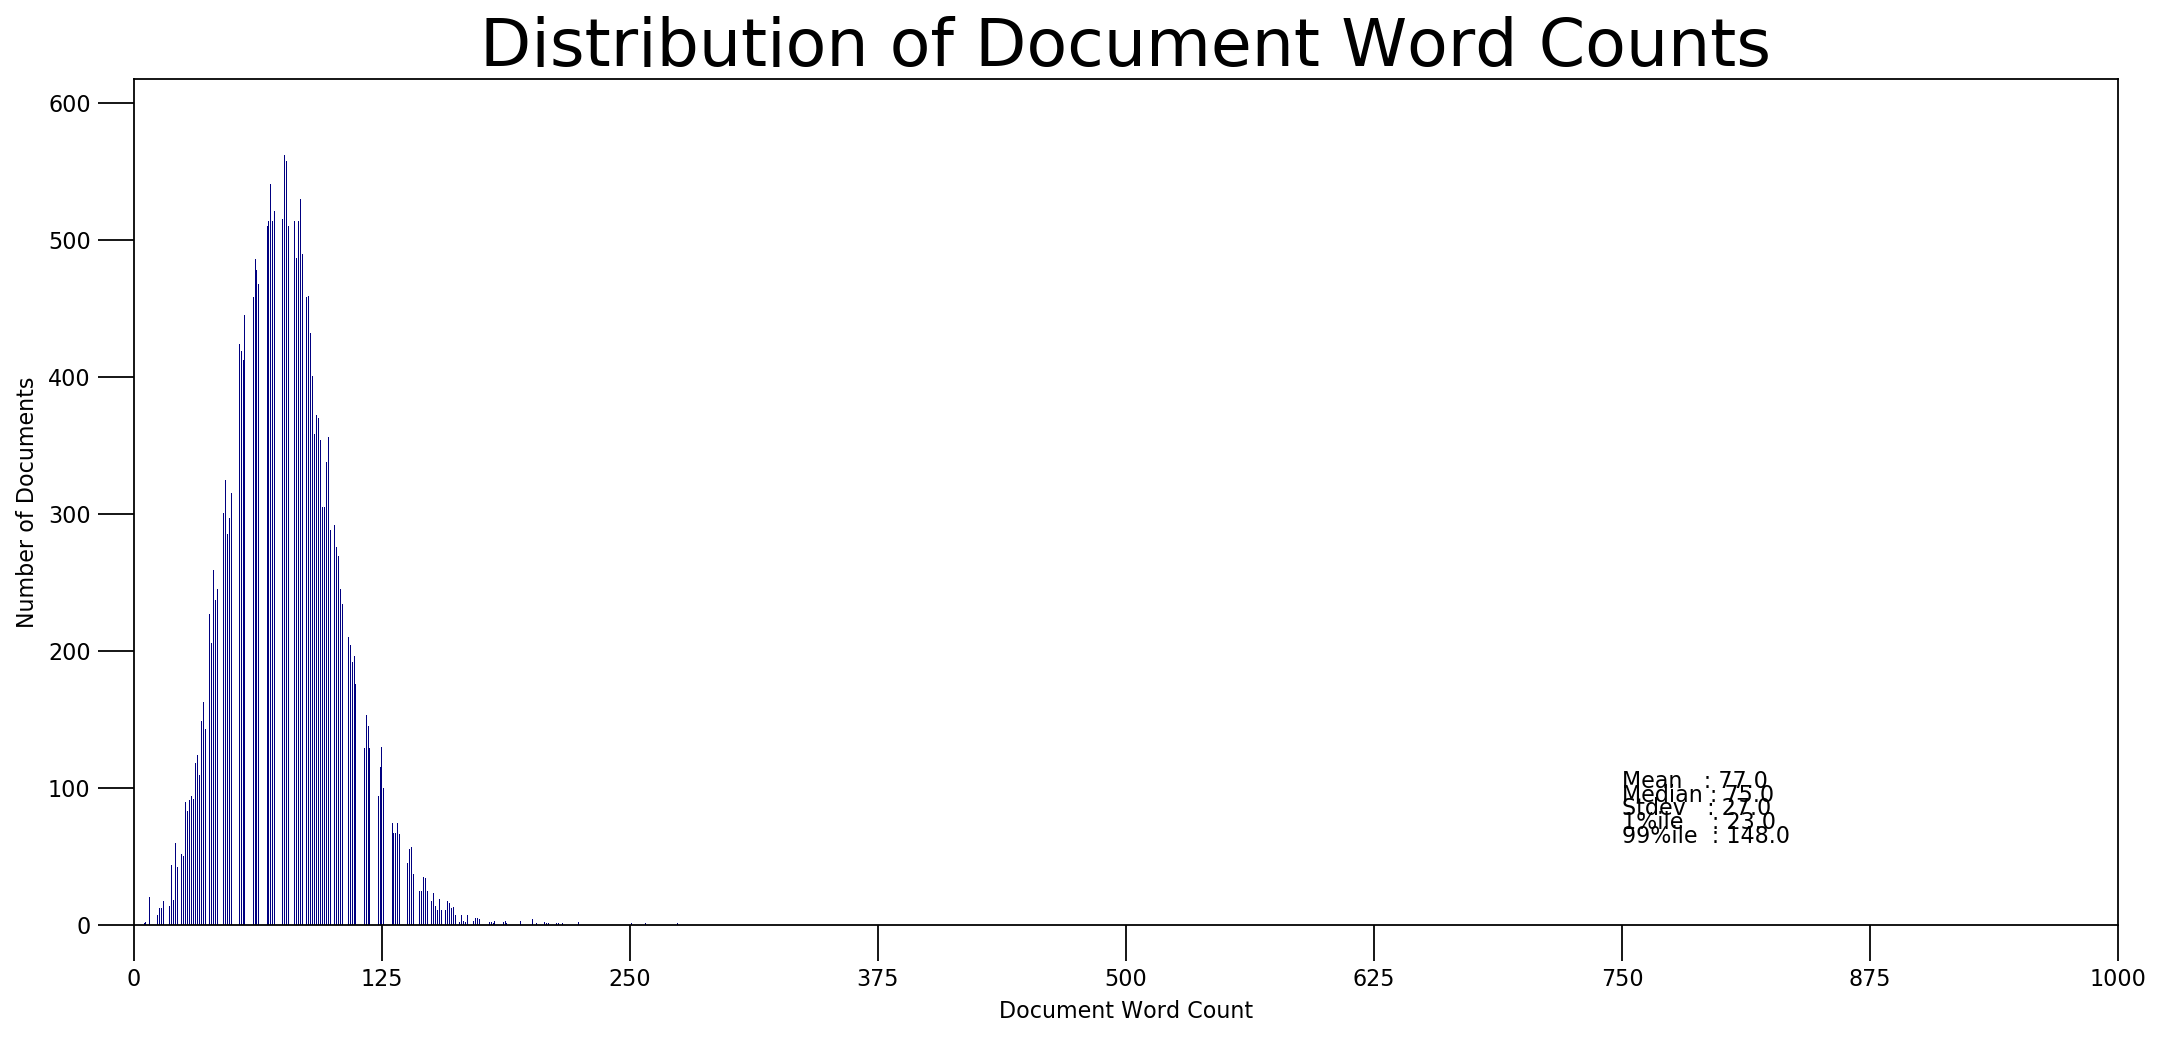

In [45]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=30))
plt.show()

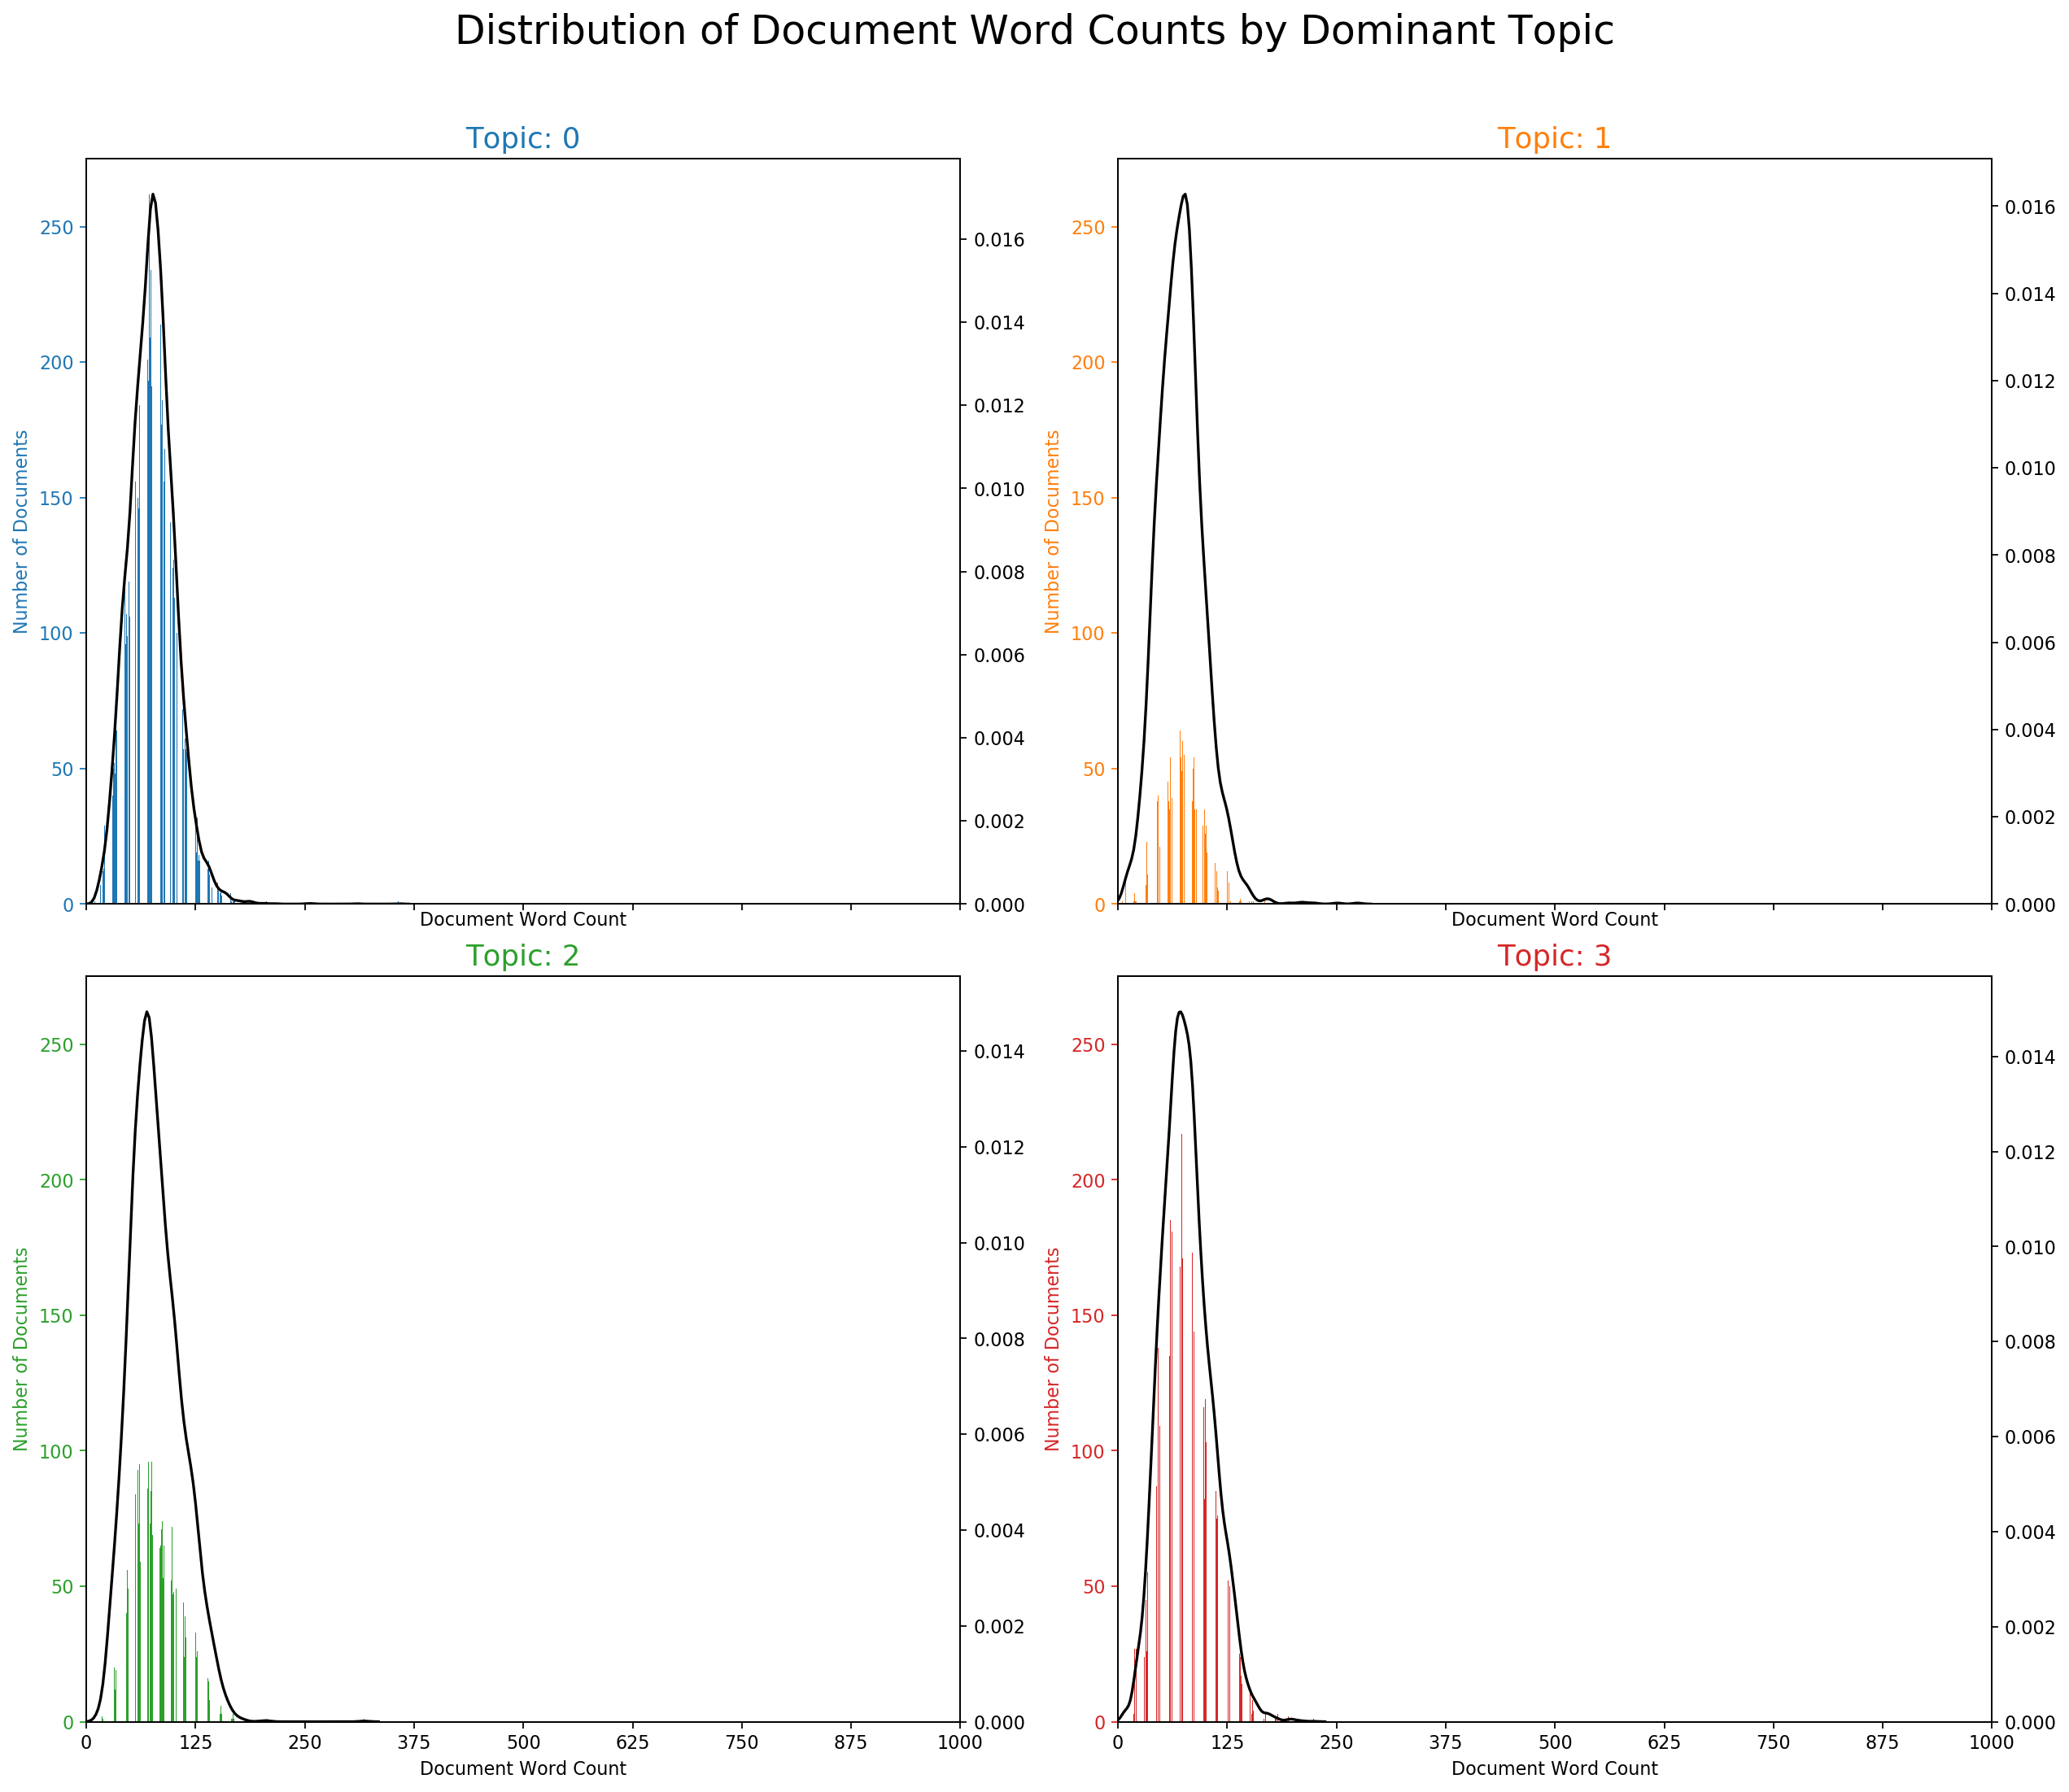

In [46]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### 3.4)-Word Clouds of Top N Keywords in Each Topic

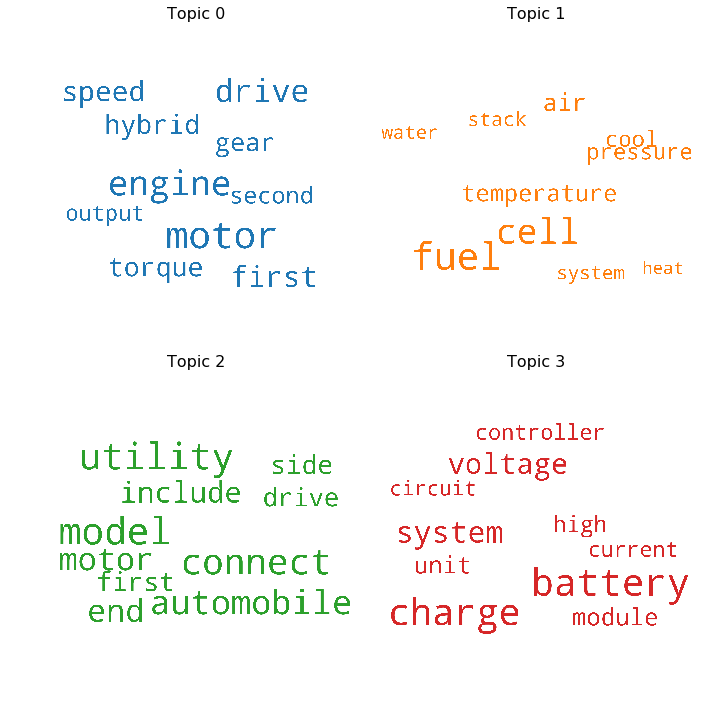

In [47]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.5)-Word Counts of Topic Keywords

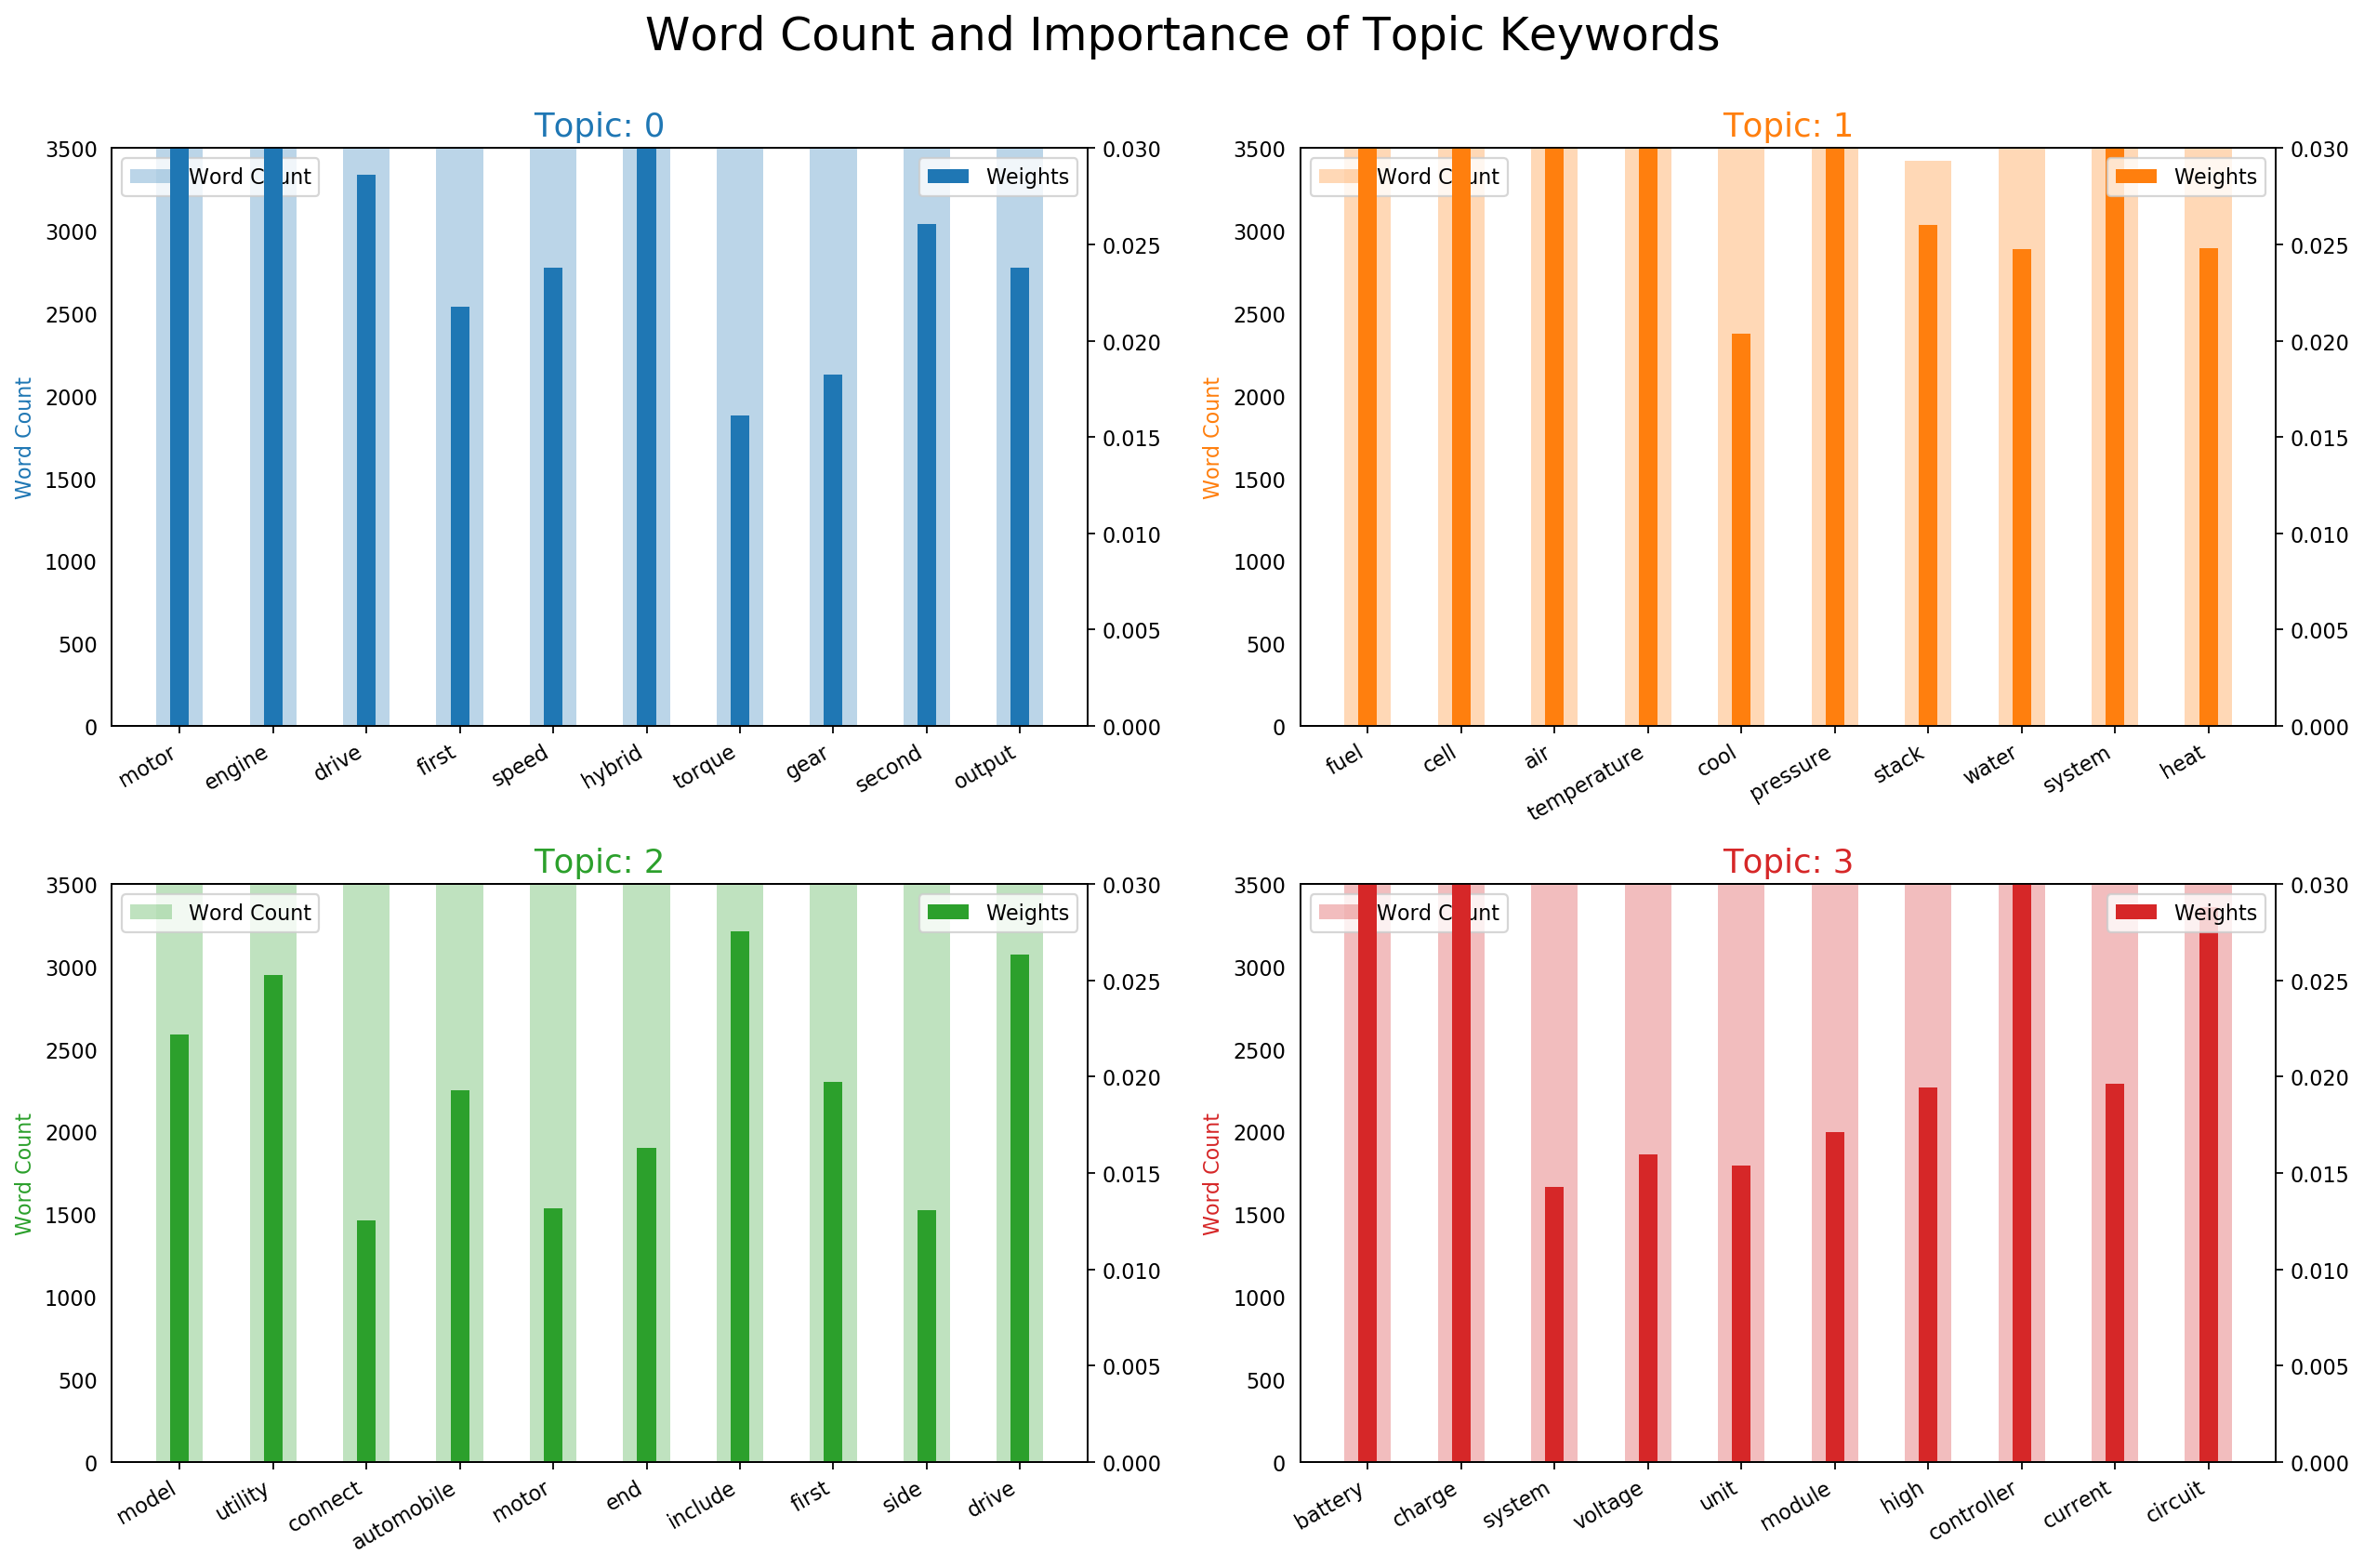

In [48]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 3.6)-Sentence Chart Colored by Topic

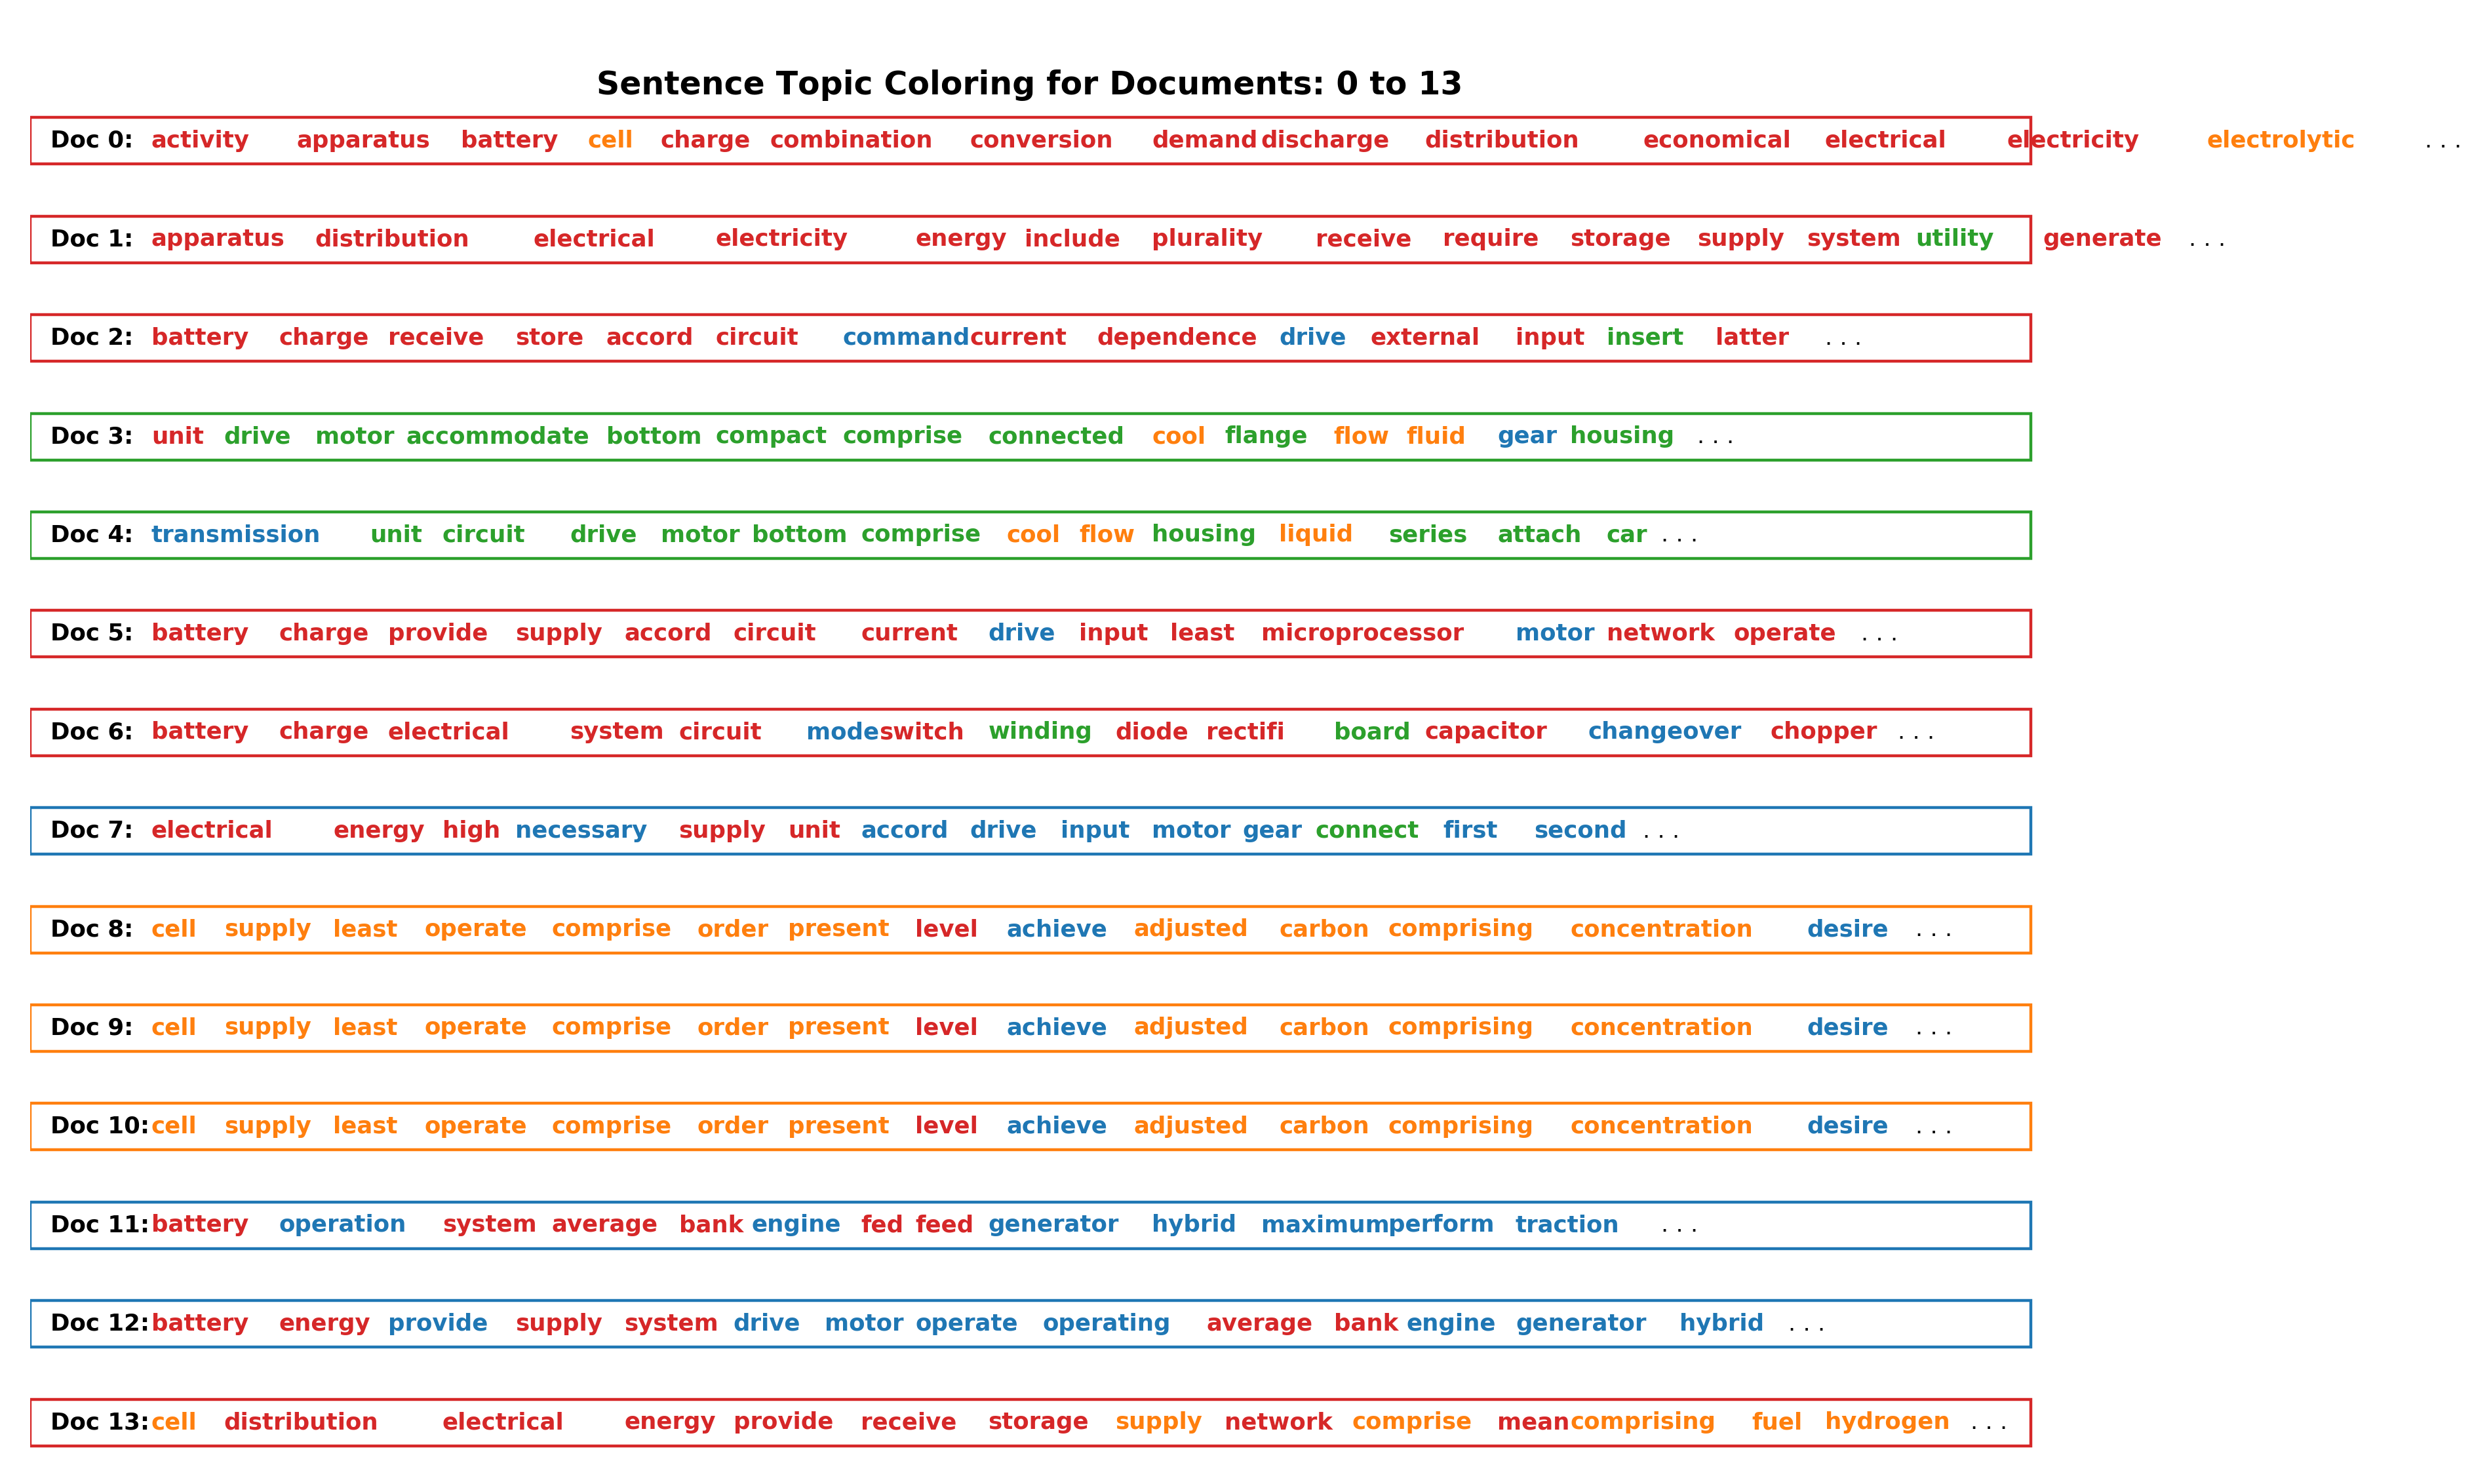

In [50]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

Colors are given from above shown plot. 

Blue for topic 0, orange for topic 1, green for topic 2 , and red for topic 3.

### 3.7)- The most discussed topics in the documents

In [51]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

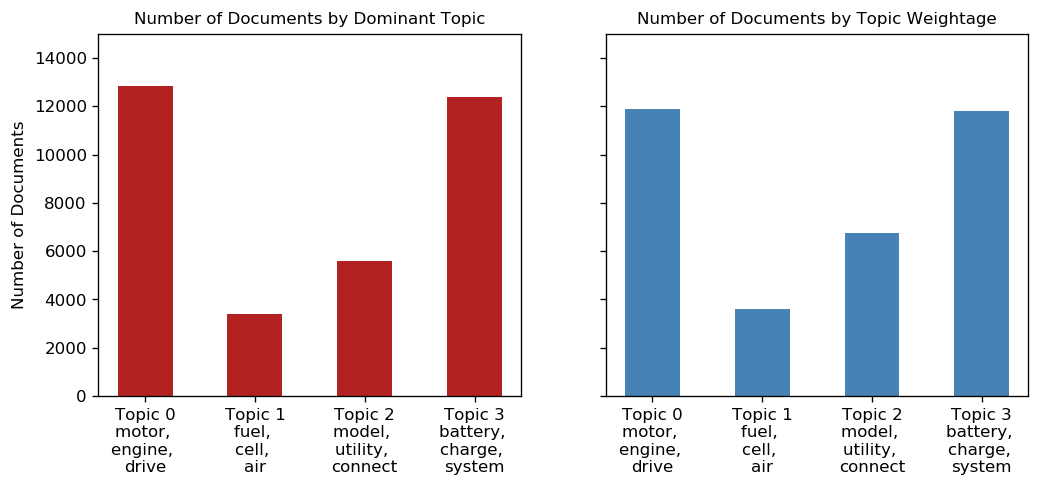

In [58]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 15000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# 4)-Visualize topics


### 4.1)- t-SNE Clustering Chart

t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [59]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 33964 samples in 0.021s...
[t-SNE] Computed neighbors for 33964 samples in 0.667s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33964
[t-SNE] Computed conditional probabilities for sample 2000 / 33964
[t-SNE] Computed conditional probabilities for sample 3000 / 33964
[t-SNE] Computed conditional probabilities for sample 4000 / 33964
[t-SNE] Computed conditional probabilities for sample 5000 / 33964
[t-SNE] Computed conditional probabilities for sample 6000 / 33964
[t-SNE] Computed conditional probabilities for sample 7000 / 33964
[t-SNE] Computed conditional probabilities for sample 8000 / 33964
[t-SNE] Computed conditional probabilities for sample 9000 / 33964
[t-SNE] Computed conditional probabilities for sample 10000 / 33964
[t-SNE] Computed conditional probabilities for sample 11000 / 33964
[t-SNE] Computed conditional probabilities for sample 12000 / 33964
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### 4.2)- pyLDAVis

In [62]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.150274 -0.154341       1        1  34.570591
3      0.074633 -0.184275       2        1  34.222229
2      0.150230  0.312113       3        1  20.664862
1     -0.375137  0.026503       4        1  10.542319, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
187   Default  30027.000000          fuel  30027.000000  30.0000  30.0000
3     Default  25744.000000          cell  25744.000000  29.0000  29.0000
2     Default  42057.000000       battery  42057.000000  28.0000  28.0000
4     Default  40471.000000        charge  40471.000000  27.0000  27.0000
206   Default  33213.000000        engine  33213.000000  26.0000  26.0000
55    Default  49629.000000         motor  49629.000000  25.0000  25.0000
139   Default  22976.000000       voltage  22976.000000  24.0000  24.0000
616   Default  10208.000000           air  10208.000000  23.0000  23.0000
123   Default  21000.000000         speed  21000.000000  22.0000  22.0000
36    Default  36527.000000        system  36527.000000  21.0000  21.0000
200   Default   9516.000000   temperature   9516.000000  20.0000  20.0000
533   Default  13268.000000         model  13268.000000  19.0000  19.0000
210   Default  19185.000000        hybrid  19185.000000  18.0000  18.0000
295   Default  19170.000000        torque  19170.000000  17.0000  17.0000
39    Default  12679.000000       utility  12679.000000  16.0000  16.0000
46    Default  34032.000000         drive  34032.000000  15.0000  15.0000
262   Default   9032.000000      pressure   9032.000000  14.0000  14.0000
73    Default   8355.000000          cool   8355.000000  13.0000  13.0000
77    Default  17541.000000          gear  17541.000000  12.0000  12.0000
93    Default  29421.000000         first  29421.000000  11.0000  11.0000
34    Default  15941.000000        supply  15941.000000  10.0000  10.0000
368   Default  14716.000000    automobile  14716.000000   9.0000   9.0000
373   Default   9300.000000           end   9300.000000   8.0000   8.0000
268   Default   6386.000000         stack   6386.000000   7.0000   7.0000
233   Default   6096.000000         water   6096.000000   6.0000   6.0000
44    Default  12280.000000       current  12280.000000   5.0000   5.0000
91    Default  20603.000000       connect  20603.000000   4.0000   4.0000
37    Default  12198.000000  transmission  12198.000000   3.0000   3.0000
1117  Default  17193.000000        module  17193.000000   2.0000   2.0000
96    Default  20231.000000        second  20231.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
495    Topic4   3200.969238           gas   3201.649658   2.2496  -4.3406
820    Topic4   3027.484863          tank   3028.165771   2.2495  -4.3963
984    Topic4   2796.884766    compressor   2797.602783   2.2495  -4.4756
26     Topic4   2747.917236          pump   2748.631592   2.2495  -4.4932
731    Topic4   2240.552734         valve   2241.229980   2.2495  -4.6973
795    Topic4   1982.471558       coolant   1983.152710   2.2494  -4.8197
813    Topic4   1708.274292       heating   1708.959229   2.2494  -4.9686
81     Topic4   1543.902100        liquid   1544.582886   2.2493  -5.0697
723    Topic4   1419.997437          pipe   1420.680542   2.2493  -5.1534
310    Topic4   1287.612061      radiator   1288.290527   2.2492  -5.2513
261    Topic4   1357.532959        outlet   1358.267212   2.2492  -5.1984
1004   Topic4   1257.713135         inlet   1258.412476   2.2492  -5.2748
1425   Topic4   1119.602295   conditioner   1120.300293   2.2491  -5.3911
494    Topic4   1081.722778       exhaust   1082.415649   2.2491  -5.4255
1048   Topic4   1035.658691        intake   1036.336914   2.2491  -5.4690
787    Topic4   1002.837830           fan   1003.519165   2.2491  -5.5012
721    